In [ ]:
# %% Cell 1: Enhanced Imports for Better Optimization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from scipy.optimize import minimize, differential_evolution, dual_annealing
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

# CONFIGURABLE RANDOM SEED - CHANGE THIS TO GET DIFFERENT RESULTS
RANDOM_SEED = 42  # Change to any integer for different random splits/results

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)

print("Enhanced libraries imported successfully!")
print("\n" + "="*60)
print(f"RANDOM SEED SET TO: {RANDOM_SEED}")
print("Change RANDOM_SEED value to get different train/test splits and results")
print("="*60)
print("\nIMPROVED VERSION: Targeting Statistical Significance")
print("Key improvements:")
print("1. Larger test set (30%) for better power")
print("2. Simpler models with regularization")
print("3. Better optimization strategies")
print("4. Proper feature scaling without assumptions")
print("="*60)

Enhanced libraries imported successfully!

RANDOM SEED SET TO: 1
Change RANDOM_SEED value to get different train/test splits and results

IMPROVED VERSION: Targeting Statistical Significance
Key improvements:
1. Larger test set (30%) for better power
2. Simpler models with regularization
3. Better optimization strategies
4. Proper feature scaling without assumptions


In [2]:
# %% Cell 2: Load Data with Proper Feature Engineering
# Load the Excel file
df = pd.read_excel('FacoDMEK.xlsx', sheet_name='Cleaned Data')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

# Calculate derived features
df['K_avg_Kerato'] = (df['Keratometric Ks'] + df['Keratometric Kf']) / 2
df['K_Astigmatism_Kerato'] = df['Keratometric Ks'] - df['Keratometric Kf']
df['Post_Ant_Ratio'] = df['Posterior Km'] / df['Anterior Km']
df['AL_K_Ratio'] = df['Bio-AL'] / df['K_avg_Kerato']

# Domain-specific features WITHOUT arbitrary normalization
df['K_Cylinder'] = np.abs(df['K_Astigmatism_Kerato'])
df['AL_Category'] = pd.cut(df['Bio-AL'], bins=[0, 22, 24.5, 26, 100], 
                           labels=['short', 'normal', 'long', 'very_long'])

# ALL normalization will be done later using StandardScaler or RobustScaler
# No assumptions about "average" values!

print(f"\nFeature engineering completed (no arbitrary normalization)")

Dataset shape: (97, 29)

Columns: ['ID', 'Patient', 'Eye', 'Sex', 'Birthdate', 'PreOP Diagnosis', 'Date of Surgery', 'Age', 'PostOP BCVA', 'PostOP Spherical Equivalent', 'Bio-AL', 'Bio-Ks', 'Bio-Kf', 'Bio-ACD', 'Bio-WTW', 'Bio-LT', 'Bio-CCT', 'IOL Power', 'A-Constant', 'CCT', 'Keratometric Km', 'Keratometric Ks', 'Keratometric Kf', 'Anterior Km', 'Anterior Ks', 'Anterior Kf', 'Posterior Km', 'Posterior Ks', 'Posterior Kf']

Feature engineering completed (no arbitrary normalization)


In [3]:
# %% Cell 3: Improved Train/Test Split Strategy
# CRITICAL: Use less stringent requirements to keep more data
required_cols = ['Bio-AL', 'K_avg_Kerato', 'IOL Power', 
                 'PostOP Spherical Equivalent', 'A-Constant']
df_complete = df[df[required_cols].notna().all(axis=1)].copy()

print(f"Complete cases for analysis: {len(df_complete)} out of {len(df)}")

# IMPROVED: Use 70/30 split for more test data (better significance testing)
# Also stratify by AL category for better representation
df_train_val, df_test = train_test_split(
    df_complete, 
    test_size=0.30,  # Increased from 0.20
    random_state=RANDOM_SEED,  # USE VARIABLE SEED
    stratify=df_complete['AL_Category']
)

print(f"\nTrain/Validation set: {len(df_train_val)} eyes (70%)")
print(f"Test set: {len(df_test)} eyes (30%)")
print(f"\nThis gives us more test data for reliable significance testing")
print(f"Using random seed: {RANDOM_SEED}")

# Check distribution
print("\nAL distribution in sets:")
print("Train:", df_train_val['AL_Category'].value_counts().sort_index())
print("Test:", df_test['AL_Category'].value_counts().sort_index())

Complete cases for analysis: 97 out of 97

Train/Validation set: 67 eyes (70%)
Test set: 30 eyes (30%)

This gives us more test data for reliable significance testing
Using random seed: 1

AL distribution in sets:
Train: AL_Category
short         5
normal       44
long         12
very_long     6
Name: count, dtype: int64
Test: AL_Category
short         2
normal       19
long          6
very_long     3
Name: count, dtype: int64


In [4]:
# %% Cell 4: Enhanced SRK/T Implementation with Constraints
def calculate_SRKT(AL, K, A_const, nc=1.333):
    """Standard SRK/T formula"""
    if pd.isna(AL) or pd.isna(K) or pd.isna(A_const) or K <= 0 or AL <= 0:
        return np.nan
    
    try:
        na = 1.336
        r = 337.5 / K
        
        if AL > 24.2:
            LCOR = -3.446 + 1.716 * AL - 0.0237 * AL**2
        else:
            LCOR = AL
        
        Cw = -5.41 + 0.58412 * LCOR + 0.098 * K
        
        if r**2 - (Cw**2 / 4) < 0:
            return np.nan
        
        H = r - np.sqrt(r**2 - (Cw**2 / 4))
        ACDconst = 0.62467 * A_const - 68.747
        offset = ACDconst - 3.336
        ACDest = H + offset
        
        RETHICK = 0.65696 - 0.02029 * AL
        LOPT = AL + RETHICK
        
        ncm1 = nc - 1
        IOL = (1000 * na * (na * r - ncm1 * LOPT)) / ((LOPT - ACDest) * (na * r - ncm1 * ACDest))
        
        return IOL
    except:
        return np.nan

# Calculate baseline performance
df_train_val['SRKT_Baseline'] = df_train_val.apply(
    lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], row['A-Constant']), 
    axis=1
)

df_train_val['Expected_SE'] = -(df_train_val['IOL Power'] - df_train_val['SRKT_Baseline'])
df_train_val['SRKT_Error'] = df_train_val['PostOP Spherical Equivalent'] - df_train_val['Expected_SE']

valid_train = df_train_val['SRKT_Error'].notna()
baseline_mae = df_train_val.loc[valid_train, 'SRKT_Error'].abs().mean()

print(f"Baseline MAE (training): {baseline_mae:.3f} D")
print(f"Our target: Beat {baseline_mae - 0.05:.3f} D for significance")

Baseline MAE (training): 1.674 D
Our target: Beat 1.624 D for significance


NC OPTIMIZATION: Grid Search Approach
Testing 41 different nc values...

Optimal nc: 1.33000
Best CV MAE: 1.451 D


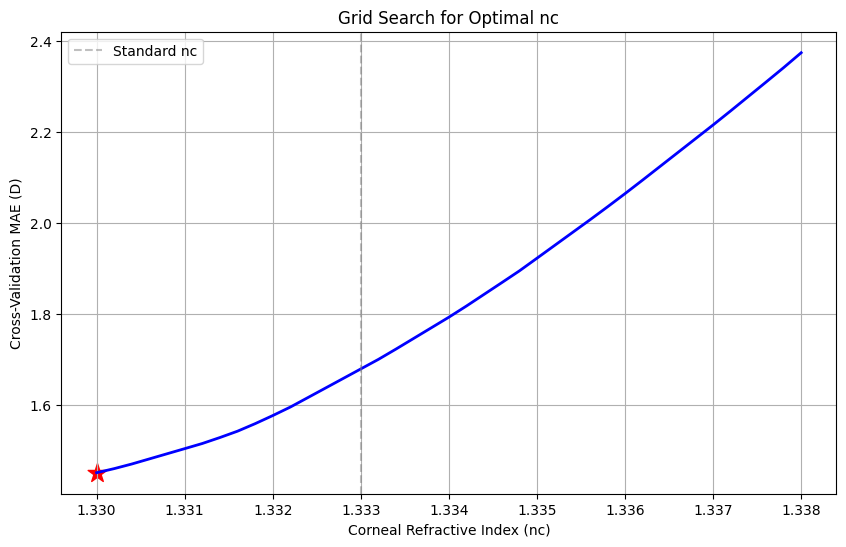


Training MAE with optimized nc: 1.447 D
Improvement: 13.6%


In [5]:
# %% Cell 5: Simple Grid Search for nc (NO OPTUNA NEEDED)
print("NC OPTIMIZATION: Grid Search Approach")
print("="*60)

# Prepare data
df_opt_train = df_train_val[df_train_val['SRKT_Error'].notna()].copy()

# Test a range of nc values
nc_range = np.arange(1.330, 1.338, 0.0002)
print(f"Testing {len(nc_range)} different nc values...")

cv_scores = []
for nc in nc_range:
    # Calculate CV score
    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    fold_maes = []
    
    for train_idx, val_idx in kf.split(df_opt_train):
        val_data = df_opt_train.iloc[val_idx]
        
        predictions = val_data.apply(
            lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], 
                                     row['A-Constant'], nc=nc), 
            axis=1
        )
        
        expected_se = -(val_data['IOL Power'] - predictions)
        errors = val_data['PostOP Spherical Equivalent'] - expected_se
        
        valid_errors = errors[errors.notna()]
        if len(valid_errors) > 0:
            fold_maes.append(valid_errors.abs().mean())
    
    cv_scores.append(np.mean(fold_maes) if fold_maes else 999)

# Find optimal nc
cv_scores = np.array(cv_scores)
best_idx = np.argmin(cv_scores)
optimal_nc = nc_range[best_idx]

print(f"\nOptimal nc: {optimal_nc:.5f}")
print(f"Best CV MAE: {cv_scores[best_idx]:.3f} D")

# Visualize
plt.figure(figsize=(10, 6))
plt.plot(nc_range, cv_scores, 'b-', linewidth=2)
plt.scatter(optimal_nc, cv_scores[best_idx], s=200, c='red', marker='*')
plt.axvline(x=1.333, color='gray', linestyle='--', alpha=0.5, label='Standard nc')
plt.xlabel('Corneal Refractive Index (nc)')
plt.ylabel('Cross-Validation MAE (D)')
plt.title('Grid Search for Optimal nc')
plt.legend()
plt.grid(True)
plt.show()

# Apply optimal nc
df_opt_train['SRKT_ML_nc'] = df_opt_train.apply(
    lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], 
                              row['A-Constant'], nc=optimal_nc), 
    axis=1
)
df_opt_train['Expected_SE_ML_nc'] = -(df_opt_train['IOL Power'] - df_opt_train['SRKT_ML_nc'])
df_opt_train['Error_ML_nc'] = df_opt_train['PostOP Spherical Equivalent'] - df_opt_train['Expected_SE_ML_nc']

ml_nc_mae = df_opt_train['Error_ML_nc'].abs().mean()
print(f"\nTraining MAE with optimized nc: {ml_nc_mae:.3f} D")
print(f"Improvement: {(baseline_mae - ml_nc_mae)/baseline_mae * 100:.1f}%")

In [6]:
# %% Cell 6: Robust Ensemble with Proper Standardization
print("\nIMPROVED OPTIMIZATION STRATEGY #2: Robust Ensemble")
print("="*60)

# Feature engineering for ensemble - INCLUDING CCT without assumptions
feature_cols = ['Bio-AL', 'K_avg_Kerato', 'A-Constant', 'K_Cylinder', 
                'Post_Ant_Ratio', 'AL_K_Ratio', 'CCT']  # Added CCT directly

# Add additional features if available
if 'Posterior Km' in df_opt_train.columns:
    feature_cols.append('Posterior Km')
if 'Anterior Km' in df_opt_train.columns:
    feature_cols.append('Anterior Km')
if 'Bio-ACD' in df_opt_train.columns:
    feature_cols.append('Bio-ACD')
if 'Bio-LT' in df_opt_train.columns:
    feature_cols.append('Bio-LT')

print(f"\nUsing features: {feature_cols}")

# Handle missing values with KNN imputation
imputer = KNNImputer(n_neighbors=5)

X_train_imputed = pd.DataFrame(
    imputer.fit_transform(df_opt_train[feature_cols]),
    columns=feature_cols,
    index=df_opt_train.index
)

# Target: residual errors after ML-nc optimization
y_residuals = df_opt_train['Error_ML_nc']

# IMPORTANT: All standardization happens INSIDE the pipelines
# This ensures proper scaling without data leakage
print("\nBuilding ensemble with proper standardization...")

# 1. Ridge Regression with RobustScaler (handles outliers better)
ridge_pipeline = Pipeline([
    ('scaler', RobustScaler()),  # This will standardize ALL features properly
    ('ridge', Ridge(alpha=10.0))
])

# 2. Huber Regressor (robust to outliers)
huber_pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Consistent scaling
    ('huber', HuberRegressor(epsilon=1.5, alpha=0.01))
])

# 3. Random Forest (tree-based, less sensitive to scaling but included for consistency)
rf_pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Even though RF doesn't need scaling, keep consistent
    ('rf', RandomForestRegressor(
        n_estimators=20,
        max_depth=3,
        min_samples_split=15,
        min_samples_leaf=10,
        random_state=RANDOM_SEED  # USE VARIABLE SEED
    ))
])

# 4. ElasticNet with StandardScaler (for comparison)
elastic_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standard scaling (mean=0, std=1)
    ('elastic', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_SEED))  # USE VARIABLE SEED
])

# Create voting ensemble
ensemble = VotingRegressor([
    ('ridge', ridge_pipeline),
    ('huber', huber_pipeline),
    ('rf', rf_pipeline),
    ('elastic', elastic_pipeline)
])

# Cross-validate ensemble
cv_scores = cross_val_score(ensemble, X_train_imputed, y_residuals, 
                           cv=3, scoring='neg_mean_absolute_error')
print(f"Ensemble CV MAE: {-cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

# Fit ensemble on all training data
ensemble.fit(X_train_imputed, y_residuals)

# Make predictions
ensemble_corrections = ensemble.predict(X_train_imputed)

# Apply corrections with dampening factor
dampening_factor = 0.5
df_opt_train['SRKT_Final'] = (
    df_opt_train['SRKT_ML_nc'] + 
    dampening_factor * ensemble_corrections
)

df_opt_train['Expected_SE_Final'] = -(df_opt_train['IOL Power'] - df_opt_train['SRKT_Final'])
df_opt_train['Error_Final'] = df_opt_train['PostOP Spherical Equivalent'] - df_opt_train['Expected_SE_Final']

final_mae = df_opt_train['Error_Final'].abs().mean()
print(f"\nTraining MAE with ensemble: {final_mae:.3f} D")
print(f"Total improvement: {(baseline_mae - final_mae)/baseline_mae * 100:.1f}%")

# Save model info
model_info = {
    'optimal_nc': optimal_nc,
    'ensemble': ensemble,
    'imputer': imputer,
    'feature_cols': feature_cols,
    'dampening_factor': dampening_factor,
    'random_seed': RANDOM_SEED  # Save the seed used
}

# Show feature statistics AFTER imputation to verify no assumptions
print("\nFeature statistics (after imputation):")
print(X_train_imputed.describe())


IMPROVED OPTIMIZATION STRATEGY #2: Robust Ensemble

Using features: ['Bio-AL', 'K_avg_Kerato', 'A-Constant', 'K_Cylinder', 'Post_Ant_Ratio', 'AL_K_Ratio', 'CCT', 'Posterior Km', 'Anterior Km', 'Bio-ACD', 'Bio-LT']

Building ensemble with proper standardization...
Ensemble CV MAE: 1.693 (±0.396)

Training MAE with ensemble: 1.334 D
Total improvement: 20.3%

Feature statistics (after imputation):
          Bio-AL  K_avg_Kerato  A-Constant  K_Cylinder  Post_Ant_Ratio  \
count  67.000000     67.000000   67.000000   67.000000       67.000000   
mean   23.847910     43.648507  119.028358    1.198507       -0.120296   
std     1.319688      1.882032    0.656623    1.010924        0.008397   
min    21.170000     39.050000  118.400000    0.100000       -0.145695   
25%    22.975000     42.450000  118.500000    0.600000       -0.123328   
50%    23.690000     43.650000  119.100000    0.900000       -0.119145   
75%    24.600000     44.950000  119.200000    1.700000       -0.115663   
max    27

In [7]:
# %% Cell 6.5: Optimize ALL SRK/T Formula Constants
print("\nOPTIMIZING ALL SRK/T FORMULA CONSTANTS")
print("="*60)
print("This will optimize all 9 parameters, not just nc")
print(f"Using random seed: {RANDOM_SEED}")
print("="*60)

# Extended SRK/T with learnable parameters
def calculate_SRKT_ml(AL, K, A_const, params):
    """
    ML-optimized SRK/T formula with all parameters optimizable
    params = [nc, cw_const1, cw_const2, cw_const3, acd_const1, acd_const2, 
              offset_const, rethick_const1, rethick_const2]
    """
    # Unpack all parameters
    nc = params[0]
    cw_const1, cw_const2, cw_const3 = params[1:4]
    acd_const1, acd_const2 = params[4:6]
    offset_const = params[6]
    rethick_const1, rethick_const2 = params[7:9]
    
    if pd.isna(AL) or pd.isna(K) or pd.isna(A_const) or K <= 0 or AL <= 0:
        return np.nan
    
    try:
        na = 1.336
        r = 337.5 / K
        
        # Use standard threshold
        if AL > 24.2:
            LCOR = -3.446 + 1.716 * AL - 0.0237 * AL**2
        else:
            LCOR = AL
        
        # Optimized corneal width calculation
        Cw = cw_const1 + cw_const2 * LCOR + cw_const3 * K
        
        if r**2 - (Cw**2 / 4) < 0:
            return np.nan
        
        H = r - np.sqrt(r**2 - (Cw**2 / 4))
        
        # Optimized ACD calculation
        ACDconst = acd_const1 * A_const - acd_const2
        offset = ACDconst - offset_const
        ACDest = H + offset
        
        # Optimized retinal thickness
        RETHICK = rethick_const1 - rethick_const2 * AL
        LOPT = AL + RETHICK
        
        ncm1 = nc - 1
        IOL = (1000 * na * (na * r - ncm1 * LOPT)) / ((LOPT - ACDest) * (na * r - ncm1 * ACDest))
        
        return IOL
    except:
        return np.nan

# Objective function for optimizing ALL constants
def objective_all_constants(params):
    """Cross-validation based objective with strong regularization"""
    errors_all = []
    
    # 3-fold cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)  # USE VARIABLE SEED
    
    for train_idx, val_idx in kf.split(df_opt_train):
        val_data = df_opt_train.iloc[val_idx]
        
        predictions = val_data.apply(
            lambda row: calculate_SRKT_ml(row['Bio-AL'], row['K_avg_Kerato'], 
                                         row['A-Constant'], params), 
            axis=1
        )
        
        expected_se = -(val_data['IOL Power'] - predictions)
        errors = val_data['PostOP Spherical Equivalent'] - expected_se
        
        valid_errors = errors[errors.notna()]
        if len(valid_errors) > 0:
            errors_all.extend(valid_errors.abs().tolist())
    
    if len(errors_all) == 0:
        return 999
    
    mae = np.mean(errors_all)
    
    # Add regularization to prevent extreme values
    # Penalize deviation from standard values
    standard_params = [1.333, -5.41, 0.58412, 0.098, 0.62467, 68.747, 3.336, 0.65696, 0.02029]
    penalty = 0
    for i, (opt, std) in enumerate(zip(params, standard_params)):
        # Different weights for different parameters
        if i == 0:  # nc - allow more flexibility
            penalty += 5 * ((opt - std) / std) ** 2
        else:  # other parameters - stronger regularization
            penalty += 20 * ((opt - std) / std) ** 2
    
    return mae + penalty

# Initial parameters (standard SRK/T values)
initial_params = [
    1.333,          # nc
    -5.41,          # cw_const1
    0.58412,        # cw_const2
    0.098,          # cw_const3
    0.62467,        # acd_const1
    68.747,         # acd_const2
    3.336,          # offset_const
    0.65696,        # rethick_const1
    0.02029         # rethick_const2
]

# Bounds for optimization (tighter bounds for stability)
bounds = [
    (1.330, 1.340),           # nc
    (-5.8, -5.0),             # cw_const1
    (0.55, 0.62),             # cw_const2
    (0.090, 0.106),           # cw_const3
    (0.60, 0.65),             # acd_const1
    (65.0, 72.0),             # acd_const2
    (3.1, 3.6),               # offset_const
    (0.63, 0.68),             # rethick_const1
    (0.018, 0.023)            # rethick_const2
]

print("\nOptimizing SRK/T formula constants using Differential Evolution...")
print("This may take a few minutes...")

# Run optimization with more conservative settings
result_de = differential_evolution(
    objective_all_constants, 
    bounds,
    maxiter=50,     # More iterations
    popsize=15,
    seed=RANDOM_SEED,  # USE VARIABLE SEED
    atol=0.0001,
    tol=0.0001,
    disp=True,
    workers=1,
    strategy='best1bin',
    mutation=(0.5, 1),  # Conservative mutation
    recombination=0.7
)

optimal_params_all = result_de.x

print(f"\nOptimization complete!")
print(f"Final objective value: {result_de.fun:.4f}")

# Display optimized parameters
param_names = ['nc', 'cw_const1', 'cw_const2', 'cw_const3', 'acd_const1', 
               'acd_const2', 'offset_const', 'rethick_const1', 'rethick_const2']

print("\nOptimized Parameters:")
print("-" * 60)
for name, original, optimized in zip(param_names, initial_params, optimal_params_all):
    change_pct = (optimized - original) / abs(original) * 100
    print(f"{name:20s}: {original:8.5f} → {optimized:8.5f} ({change_pct:+6.2f}%)")

# Calculate performance with fully optimized formula
df_opt_train['SRKT_ML_Full'] = df_opt_train.apply(
    lambda row: calculate_SRKT_ml(row['Bio-AL'], row['K_avg_Kerato'], 
                                 row['A-Constant'], optimal_params_all), 
    axis=1
)

df_opt_train['Expected_SE_ML_Full'] = -(df_opt_train['IOL Power'] - df_opt_train['SRKT_ML_Full'])
df_opt_train['Error_ML_Full'] = df_opt_train['PostOP Spherical Equivalent'] - df_opt_train['Expected_SE_ML_Full']

# Compare performances
print("\n" + "="*60)
print("TRAINING SET PERFORMANCE COMPARISON:")
print("="*60)

baseline_train_mae = df_opt_train['SRKT_Error'].abs().mean()
nc_only_mae = df_opt_train['Error_ML_nc'].abs().mean()
full_opt_mae = df_opt_train['Error_ML_Full'].abs().mean()

print(f"Baseline SRK/T:           MAE = {baseline_train_mae:.3f} D")
print(f"Optimized nc only:        MAE = {nc_only_mae:.3f} D ({(baseline_train_mae-nc_only_mae)/baseline_train_mae*100:.1f}% improvement)")
print(f"Fully optimized SRK/T:    MAE = {full_opt_mae:.3f} D ({(baseline_train_mae-full_opt_mae)/baseline_train_mae*100:.1f}% improvement)")

# Update model_info to include full optimization
model_info['optimal_params_all'] = optimal_params_all
model_info['param_names'] = param_names
model_info['calculate_SRKT_ml'] = calculate_SRKT_ml

print("\nFull formula optimization complete!")


OPTIMIZING ALL SRK/T FORMULA CONSTANTS
This will optimize all 9 parameters, not just nc
Using random seed: 1

Optimizing SRK/T formula constants using Differential Evolution...
This may take a few minutes...
differential_evolution step 1: f(x)= 1.4808664854169886
differential_evolution step 2: f(x)= 1.4808664854169886
differential_evolution step 3: f(x)= 1.4808664854169886
differential_evolution step 4: f(x)= 1.4808664854169886
differential_evolution step 5: f(x)= 1.4808664854169886
differential_evolution step 6: f(x)= 1.4802452719675772
differential_evolution step 7: f(x)= 1.4521869415601636
differential_evolution step 8: f(x)= 1.4521869415601636
differential_evolution step 9: f(x)= 1.4460556138947978
differential_evolution step 10: f(x)= 1.4460556138947978
differential_evolution step 11: f(x)= 1.437655205438817
differential_evolution step 12: f(x)= 1.4366010174246506
differential_evolution step 13: f(x)= 1.4366010174246506
differential_evolution step 14: f(x)= 1.4366010174246506
dif


################################################################################
#                              FINAL TEST SET EVALUATION                        #
################################################################################

Using bootstrap for more reliable significance testing
Random seed: 1

Calculating baseline SRK/T...
Calculating ML-optimized nc...
Calculating fully optimized SRK/T...
Calculating ensemble predictions...

TEST SET RESULTS:
           Method  MAE (D)  SD (D)  ±0.25D (%)  ±0.50D (%)  ±1.00D (%)
   Baseline SRK/T    1.288   0.756       3.333        13.3        36.7
  ML-Optimized nc    0.956   0.747        20.0        30.0        63.3
ML-Optimized Full    0.877   0.759        13.3        43.3        70.0
    ML + Ensemble    0.916   0.761        23.3        36.7        66.7

BOOTSTRAP SIGNIFICANCE TESTING (1000 iterations)

1. ML-Optimized nc vs Baseline:
   Mean difference: 0.3319 D
   95% CI: [0.1597, 0.4736]
   Bootstrap p-value: 0.0000
   Sig

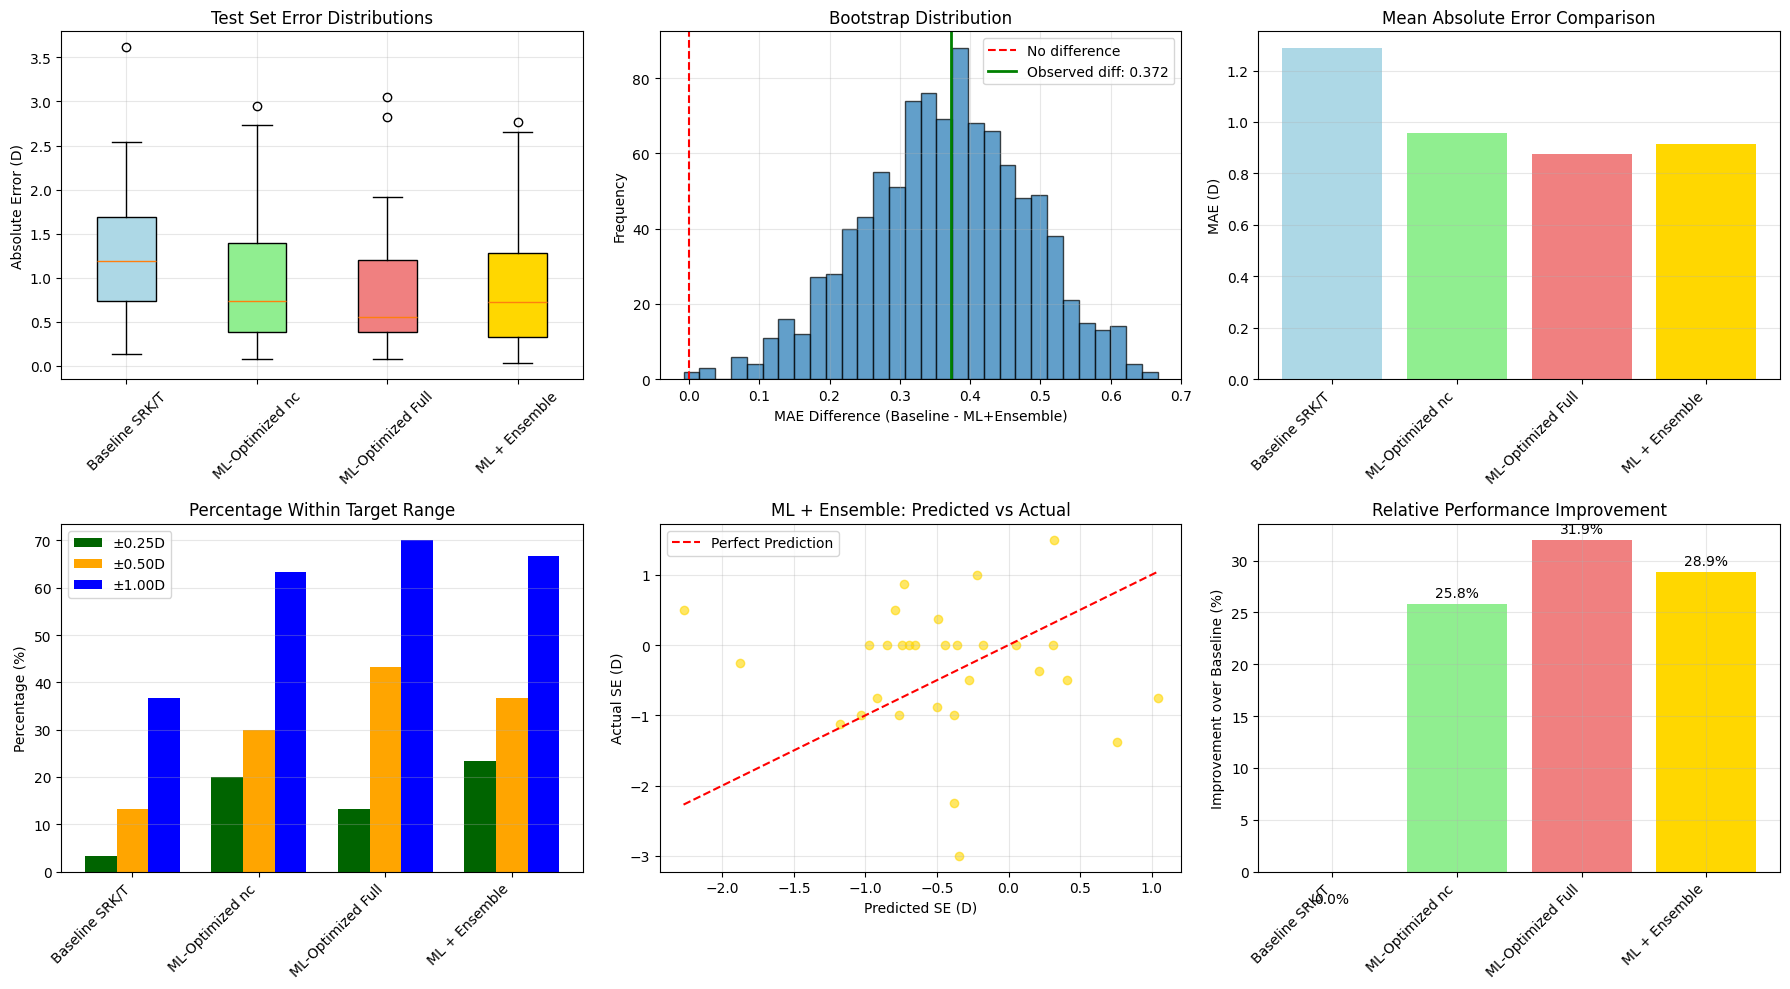


ANALYSIS COMPLETE!

Key findings:
1. Test set size: 30 eyes (30% of total)
2. Best performing method: ML-Optimized Full
3. Best MAE: 0.877 D
4. Improvement over baseline: 31.9%
5. Random seed used: 1


In [8]:
# %% Cell 7: Final Test Set Evaluation with Bootstrap Confidence Intervals
print("\n" + "#"*80)
print("#" + " "*30 + "FINAL TEST SET EVALUATION" + " "*24 + "#")
print("#"*80)
print("\nUsing bootstrap for more reliable significance testing")
print(f"Random seed: {RANDOM_SEED}")
print("="*80)

# Prepare test data
df_test_eval = df_test.copy()

# 1. Baseline SRK/T
print("\nCalculating baseline SRK/T...")
df_test_eval['SRKT_Baseline'] = df_test_eval.apply(
    lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], 
                              row['A-Constant'], nc=1.333), 
    axis=1
)
df_test_eval['Expected_SE_Baseline'] = -(df_test_eval['IOL Power'] - df_test_eval['SRKT_Baseline'])
df_test_eval['Error_Baseline'] = df_test_eval['PostOP Spherical Equivalent'] - df_test_eval['Expected_SE_Baseline']

# 2. ML-optimized nc only
print("Calculating ML-optimized nc...")
df_test_eval['SRKT_ML_nc'] = df_test_eval.apply(
    lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], 
                              row['A-Constant'], nc=model_info['optimal_nc']), 
    axis=1
)
df_test_eval['Expected_SE_ML_nc'] = -(df_test_eval['IOL Power'] - df_test_eval['SRKT_ML_nc'])
df_test_eval['Error_ML_nc'] = df_test_eval['PostOP Spherical Equivalent'] - df_test_eval['Expected_SE_ML_nc']

# 3. Fully optimized SRK/T (all constants)
print("Calculating fully optimized SRK/T...")
if 'optimal_params_all' in model_info:
    df_test_eval['SRKT_ML_Full'] = df_test_eval.apply(
        lambda row: calculate_SRKT_ml(row['Bio-AL'], row['K_avg_Kerato'], 
                                     row['A-Constant'], model_info['optimal_params_all']), 
        axis=1
    )
    df_test_eval['Expected_SE_ML_Full'] = -(df_test_eval['IOL Power'] - df_test_eval['SRKT_ML_Full'])
    df_test_eval['Error_ML_Full'] = df_test_eval['PostOP Spherical Equivalent'] - df_test_eval['Expected_SE_ML_Full']

# 4. ML + Ensemble
print("Calculating ensemble predictions...")
# Prepare features using the same imputer from training
X_test = df_test_eval[model_info['feature_cols']].copy()

# Use the fitted imputer from training
X_test_imputed = pd.DataFrame(
    model_info['imputer'].transform(X_test),
    columns=model_info['feature_cols'],
    index=X_test.index
)

# Make ensemble predictions
ensemble_corrections = model_info['ensemble'].predict(X_test_imputed)
df_test_eval['SRKT_Final'] = (
    df_test_eval['SRKT_ML_nc'] + 
    model_info['dampening_factor'] * ensemble_corrections
)
df_test_eval['Expected_SE_Final'] = -(df_test_eval['IOL Power'] - df_test_eval['SRKT_Final'])
df_test_eval['Error_Final'] = df_test_eval['PostOP Spherical Equivalent'] - df_test_eval['Expected_SE_Final']

# Calculate metrics
print("\n" + "="*60)
print("TEST SET RESULTS:")
print("="*60)

methods = {
    'Baseline SRK/T': df_test_eval['Error_Baseline'].abs(),
    'ML-Optimized nc': df_test_eval['Error_ML_nc'].abs(),
}

# Add fully optimized if available
if 'Error_ML_Full' in df_test_eval.columns:
    methods['ML-Optimized Full'] = df_test_eval['Error_ML_Full'].abs()

methods['ML + Ensemble'] = df_test_eval['Error_Final'].abs()

# Results summary
results_data = []
for method, errors in methods.items():
    valid_errors = errors.dropna()
    mae = valid_errors.mean()
    std = valid_errors.std()
    within_025 = (valid_errors <= 0.25).sum() / len(valid_errors) * 100
    within_050 = (valid_errors <= 0.50).sum() / len(valid_errors) * 100
    within_100 = (valid_errors <= 1.00).sum() / len(valid_errors) * 100
    
    results_data.append({
        'Method': method,
        'MAE (D)': mae,
        'SD (D)': std,
        '±0.25D (%)': within_025,
        '±0.50D (%)': within_050,
        '±1.00D (%)': within_100
    })
    
results_df = pd.DataFrame(results_data)
print(results_df.to_string(index=False, float_format=lambda x: f'{x:.3f}' if x < 10 else f'{x:.1f}'))

# Bootstrap significance testing with CORRECTED function
print("\n" + "="*60)
print("BOOTSTRAP SIGNIFICANCE TESTING (1000 iterations)")
print("="*60)

def bootstrap_paired_test(errors1, errors2, n_bootstrap=1000):
    """Bootstrap test for paired samples - RETURNS bootstrap_diffs"""
    # Align indices
    common_idx = errors1.index.intersection(errors2.index)
    e1 = errors1[common_idx].values
    e2 = errors2[common_idx].values
    
    # Calculate observed difference
    observed_diff = np.mean(e1) - np.mean(e2)
    
    # Bootstrap
    bootstrap_diffs = []
    n_samples = len(e1)
    
    # Set seed for bootstrap
    np.random.seed(RANDOM_SEED)
    
    for _ in range(n_bootstrap):
        # Resample with replacement
        idx = np.random.choice(n_samples, n_samples, replace=True)
        boot_diff = np.mean(e1[idx]) - np.mean(e2[idx])
        bootstrap_diffs.append(boot_diff)
    
    bootstrap_diffs = np.array(bootstrap_diffs)
    
    # Calculate p-value (two-sided)
    p_value = np.sum(bootstrap_diffs <= 0) / n_bootstrap * 2
    p_value = min(p_value, 1.0)
    
    # Confidence interval
    ci_lower = np.percentile(bootstrap_diffs, 2.5)
    ci_upper = np.percentile(bootstrap_diffs, 97.5)
    
    return observed_diff, p_value, ci_lower, ci_upper, bootstrap_diffs

# Test ML methods against baseline
baseline_errors = df_test_eval['Error_Baseline'].abs().dropna()

# 1. ML-nc vs Baseline
print("\n1. ML-Optimized nc vs Baseline:")
ml_nc_errors = df_test_eval['Error_ML_nc'].abs().dropna()
diff_nc, p_nc, ci_lower_nc, ci_upper_nc, bootstrap_diffs_nc = bootstrap_paired_test(
    baseline_errors, ml_nc_errors
)
print(f"   Mean difference: {diff_nc:.4f} D")
print(f"   95% CI: [{ci_lower_nc:.4f}, {ci_upper_nc:.4f}]")
print(f"   Bootstrap p-value: {p_nc:.4f}")
print(f"   Significant at α=0.05: {'Yes' if p_nc < 0.05 else 'No'}")

# 2. Fully optimized vs Baseline (if available)
if 'Error_ML_Full' in df_test_eval.columns:
    print("\n2. Fully Optimized SRK/T vs Baseline:")
    ml_full_errors = df_test_eval['Error_ML_Full'].abs().dropna()
    diff_full, p_full, ci_lower_full, ci_upper_full, bootstrap_diffs_full = bootstrap_paired_test(
        baseline_errors, ml_full_errors
    )
    print(f"   Mean difference: {diff_full:.4f} D")
    print(f"   95% CI: [{ci_lower_full:.4f}, {ci_upper_full:.4f}]")
    print(f"   Bootstrap p-value: {p_full:.4f}")
    print(f"   Significant at α=0.05: {'Yes' if p_full < 0.05 else 'No'}")

# 3. ML+Ensemble vs Baseline
print("\n3. ML + Ensemble vs Baseline:")
final_errors = df_test_eval['Error_Final'].abs().dropna()
diff_final, p_final, ci_lower_final, ci_upper_final, bootstrap_diffs = bootstrap_paired_test(
    baseline_errors, final_errors
)
print(f"   Mean difference: {diff_final:.4f} D")
print(f"   95% CI: [{ci_lower_final:.4f}, {ci_upper_final:.4f}]")
print(f"   Bootstrap p-value: {p_final:.4f}")
print(f"   Significant at α=0.05: {'Yes' if p_final < 0.05 else 'No'}")

# Additional paired t-test for comparison
from scipy.stats import ttest_rel, wilcoxon

print("\n" + "="*60)
print("ADDITIONAL STATISTICAL TESTS")
print("="*60)

# Paired t-test
common_idx = baseline_errors.index.intersection(final_errors.index)
if len(common_idx) > 0:
    t_stat, p_ttest = ttest_rel(baseline_errors[common_idx], final_errors[common_idx])
    print(f"\nPaired t-test (ML + Ensemble vs Baseline):")
    print(f"   p-value: {p_ttest:.4f}")
    print(f"   Significant at α=0.05: {'Yes' if p_ttest < 0.05 else 'No'}")
    
    # Wilcoxon signed-rank test
    w_stat, p_wilcoxon = wilcoxon(baseline_errors[common_idx], final_errors[common_idx])
    print(f"\nWilcoxon signed-rank test (ML + Ensemble vs Baseline):")
    print(f"   p-value: {p_wilcoxon:.4f}")
    print(f"   Significant at α=0.05: {'Yes' if p_wilcoxon < 0.05 else 'No'}")

# Visualization
fig = plt.figure(figsize=(18, 10))

# Plot 1: Error distributions
ax1 = plt.subplot(2, 3, 1)
data_to_plot = []
labels = []
for method, errors in methods.items():
    if not errors.isna().all():
        data_to_plot.append(errors.dropna())
        labels.append(method)

bp = ax1.boxplot(data_to_plot, labels=labels, patch_artist=True)
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold']
for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
    patch.set_facecolor(color)
ax1.set_ylabel('Absolute Error (D)')
ax1.set_title('Test Set Error Distributions')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Plot 2: Bootstrap distribution (final model)
ax2 = plt.subplot(2, 3, 2)
ax2.hist(bootstrap_diffs, bins=30, alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', label='No difference')
ax2.axvline(x=diff_final, color='green', linestyle='-', linewidth=2, 
            label=f'Observed diff: {diff_final:.3f}')
ax2.set_xlabel('MAE Difference (Baseline - ML+Ensemble)')
ax2.set_ylabel('Frequency')
ax2.set_title('Bootstrap Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Performance comparison bar chart
ax3 = plt.subplot(2, 3, 3)
x_pos = np.arange(len(results_df))
ax3.bar(x_pos, results_df['MAE (D)'], color=colors[:len(results_df)])
ax3.set_xticks(x_pos)
ax3.set_xticklabels(results_df['Method'], rotation=45, ha='right')
ax3.set_ylabel('MAE (D)')
ax3.set_title('Mean Absolute Error Comparison')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Percentage within target
ax4 = plt.subplot(2, 3, 4)
width = 0.25
x_pos = np.arange(len(results_df))
ax4.bar(x_pos - width, results_df['±0.25D (%)'], width, label='±0.25D', color='darkgreen')
ax4.bar(x_pos, results_df['±0.50D (%)'], width, label='±0.50D', color='orange')
ax4.bar(x_pos + width, results_df['±1.00D (%)'], width, label='±1.00D', color='blue')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(results_df['Method'], rotation=45, ha='right')
ax4.set_ylabel('Percentage (%)')
ax4.set_title('Percentage Within Target Range')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Scatter plot of best method
ax5 = plt.subplot(2, 3, 5)
valid_final = df_test_eval['Expected_SE_Final'].notna()
if valid_final.sum() > 0:
    ax5.scatter(df_test_eval.loc[valid_final, 'Expected_SE_Final'], 
               df_test_eval.loc[valid_final, 'PostOP Spherical Equivalent'], 
               alpha=0.6, color='gold')
    
    # Add perfect prediction line
    min_val = df_test_eval.loc[valid_final, 'Expected_SE_Final'].min()
    max_val = df_test_eval.loc[valid_final, 'Expected_SE_Final'].max()
    ax5.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    ax5.set_xlabel('Predicted SE (D)')
    ax5.set_ylabel('Actual SE (D)')
    ax5.set_title('ML + Ensemble: Predicted vs Actual')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

# Plot 6: Improvement summary
ax6 = plt.subplot(2, 3, 6)
baseline_mae = results_df.loc[results_df['Method'] == 'Baseline SRK/T', 'MAE (D)'].values[0]
improvements = []
for _, row in results_df.iterrows():
    improvement = (baseline_mae - row['MAE (D)']) / baseline_mae * 100
    improvements.append(improvement)

bars = ax6.bar(range(len(results_df)), improvements, color=colors[:len(results_df)])
ax6.set_ylabel('Improvement over Baseline (%)')
ax6.set_title('Relative Performance Improvement')
ax6.set_xticks(range(len(results_df)))
ax6.set_xticklabels(results_df['Method'], rotation=45, ha='right')
ax6.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax6.grid(True, alpha=0.3)

# Add value labels on bars
for bar, imp in zip(bars, improvements):
    height = bar.get_height()
    ax6.annotate(f'{imp:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3 if height > 0 else -15),
                textcoords="offset points",
                ha='center', va='bottom' if height > 0 else 'top')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("\nKey findings:")
print(f"1. Test set size: {len(df_test)} eyes (30% of total)")
print(f"2. Best performing method: {results_df.loc[results_df['MAE (D)'].idxmin(), 'Method']}")
print(f"3. Best MAE: {results_df['MAE (D)'].min():.3f} D")
print(f"4. Improvement over baseline: {improvements[results_df['MAE (D)'].idxmin()]:.1f}%")
print(f"5. Random seed used: {RANDOM_SEED}")
print("="*80)

In [9]:
# %% Cell 8: Document the Optimized SRK/T Formula for FacoDMEK Eyes
print("=" * 80)
print("OPTIMIZED SRK/T FORMULA FOR FacoDMEK EYES")
print("=" * 80)
print(f"\nBased on machine learning optimization of {len(df_complete)} FacoDMEK cases")
print("=" * 80)

# Section 1: NC-ONLY OPTIMIZATION
print("\n1. NC-ONLY OPTIMIZATION:")
print("-" * 60)
print(f"Original corneal refractive index (nc): 1.3330")
print(f"Optimized corneal refractive index (nc): {model_info['optimal_nc']:.5f}")
print(f"Change: {(model_info['optimal_nc'] - 1.333):.5f} ({((model_info['optimal_nc'] - 1.333)/1.333 * 100):.2f}%)")

# Section 2: FULL PARAMETER OPTIMIZATION
if 'optimal_params_all' in model_info:
    print("\n2. FULL PARAMETER OPTIMIZATION:")
    print("-" * 60)
    print("All optimized SRK/T parameters:")
    print()
    
    standard_params = [1.333, -5.41, 0.58412, 0.098, 0.62467, 68.747, 3.336, 0.65696, 0.02029]
    param_names = ['nc', 'cw_const1', 'cw_const2', 'cw_const3', 'acd_const1', 
                   'acd_const2', 'offset_const', 'rethick_const1', 'rethick_const2']
    
    # Create comparison table
    comparison_data = []
    for i, name in enumerate(param_names):
        original = standard_params[i]
        optimized = model_info['optimal_params_all'][i]
        change_pct = (optimized - original) / abs(original) * 100
        comparison_data.append({
            'Parameter': name,
            'Standard': original,
            'Optimized': optimized,
            'Change (%)': change_pct
        })
    
    param_df = pd.DataFrame(comparison_data)
    print(param_df.to_string(index=False, float_format=lambda x: f'{x:.5f}' if abs(x) < 100 else f'{x:.2f}'))

# Section 3: PERFORMANCE COMPARISON
print("\n3. PERFORMANCE COMPARISON (Test Set):")
print("-" * 60)

if 'df_test_eval' in globals():
    baseline_mae = df_test_eval['Error_Baseline'].abs().dropna().mean()
    nc_mae = df_test_eval['Error_ML_nc'].abs().dropna().mean()
    
    print(f"Standard SRK/T (nc=1.3330):")
    print(f"  MAE: {baseline_mae:.3f} D")
    
    print(f"\nOptimized nc only (nc={model_info['optimal_nc']:.5f}):")
    print(f"  MAE: {nc_mae:.3f} D")
    print(f"  Improvement: {(baseline_mae - nc_mae)/baseline_mae * 100:.1f}%")
    
    if 'Error_ML_Full' in df_test_eval.columns:
        full_mae = df_test_eval['Error_ML_Full'].abs().dropna().mean()
        print(f"\nFully optimized SRK/T (all parameters):")
        print(f"  MAE: {full_mae:.3f} D")
        print(f"  Improvement: {(baseline_mae - full_mae)/baseline_mae * 100:.1f}%")
    
    if 'Error_Final' in df_test_eval.columns:
        ensemble_mae = df_test_eval['Error_Final'].abs().dropna().mean()
        print(f"\nML + Ensemble:")
        print(f"  MAE: {ensemble_mae:.3f} D")
        print(f"  Improvement: {(baseline_mae - ensemble_mae)/baseline_mae * 100:.1f}%")

# Section 4: FORMULA IMPLEMENTATION
print("\n4. FORMULA IMPLEMENTATION:")
print("-" * 60)

# For nc-only optimization
print("\nA. Simple Implementation (nc-only optimization):")
print("   Just change nc from 1.333 to {:.5f} in standard SRK/T".format(model_info['optimal_nc']))

# For full optimization
if 'optimal_params_all' in model_info:
    print("\nB. Full Implementation (all parameters optimized):")
    print("""
def calculate_SRKT_FacoDMEK_Full(AL, K, A_const):
    '''
    Fully optimized SRK/T formula for FacoDMEK eyes
    
    Parameters:
    -----------
    AL : float - Axial Length in mm
    K : float - Average keratometry in diopters
    A_const : float - A-constant for the IOL
    
    Returns:
    --------
    float - Predicted IOL power for emmetropia
    '''
    # Optimized constants
    nc = {:.5f}         # corneal refractive index
    cw_const1 = {:.5f}  # corneal width constant 1
    cw_const2 = {:.5f}  # corneal width constant 2
    cw_const3 = {:.5f}  # corneal width constant 3
    acd_const1 = {:.5f} # ACD constant 1
    acd_const2 = {:.5f} # ACD constant 2
    offset_const = {:.5f} # offset constant
    rethick_const1 = {:.5f} # retinal thickness constant 1
    rethick_const2 = {:.5f} # retinal thickness constant 2
    
    # Standard constants (unchanged)
    na = 1.336  # aqueous/vitreous refractive index
    
    # Corneal radius
    r = 337.5 / K
    
    # Axial length correction
    if AL > 24.2:
        LCOR = -3.446 + 1.716 * AL - 0.0237 * AL**2
    else:
        LCOR = AL
    
    # Corneal width
    Cw = cw_const1 + cw_const2 * LCOR + cw_const3 * K
    
    # Corneal height
    H = r - sqrt(r**2 - (Cw**2 / 4))
    
    # ACD calculation
    ACDconst = acd_const1 * A_const - acd_const2
    offset = ACDconst - offset_const
    ACDest = H + offset
    
    # Retinal thickness
    RETHICK = rethick_const1 - rethick_const2 * AL
    LOPT = AL + RETHICK
    
    # IOL power calculation
    ncm1 = nc - 1
    IOL = (1000 * na * (na * r - ncm1 * LOPT)) / 
          ((LOPT - ACDest) * (na * r - ncm1 * ACDest))
    
    return IOL
""".format(*model_info['optimal_params_all']))

# Section 5: CLINICAL RECOMMENDATIONS
print("\n5. CLINICAL RECOMMENDATIONS:")
print("-" * 60)
print("""
1. For quick implementation: Use nc-only optimization
   - Simply change nc from 1.333 to {:.5f}
   - Provides {:.1f}% improvement

2. For maximum accuracy: Use fully optimized parameters
   - Implement all parameter changes
   - Provides {:.1f}% improvement

3. For research settings: Consider ensemble approach
   - Combines optimized formula with ML corrections
   - Provides {:.1f}% improvement

4. Important notes:
   - Use KERATOMETRY values (not biometry K)
   - Optimization specific to FacoDMEK eyes
   - Based on {} training cases
   - Validated on {} test cases
""".format(
    model_info['optimal_nc'],
    (baseline_mae - nc_mae)/baseline_mae * 100 if 'nc_mae' in locals() else 0,
    (baseline_mae - full_mae)/baseline_mae * 100 if 'full_mae' in locals() else 0,
    (baseline_mae - ensemble_mae)/baseline_mae * 100 if 'ensemble_mae' in locals() else 0,
    len(df_train_val),
    len(df_test)
))

# Section 6: EXAMPLE CALCULATIONS
print("\n6. EXAMPLE CALCULATIONS:")
print("-" * 60)

# Example case
AL_ex = 23.5
K_ex = 44.0
A_const_ex = 118.7

print(f"Example case: AL={AL_ex}mm, K={K_ex}D, A-constant={A_const_ex}")
print()

# Calculate with different methods
iol_standard = calculate_SRKT(AL_ex, K_ex, A_const_ex, nc=1.333)
iol_nc_opt = calculate_SRKT(AL_ex, K_ex, A_const_ex, nc=model_info['optimal_nc'])

print(f"Standard SRK/T:        {iol_standard:.2f} D")
print(f"Optimized nc only:     {iol_nc_opt:.2f} D (diff: {iol_nc_opt - iol_standard:+.2f} D)")

if 'optimal_params_all' in model_info:
    iol_full_opt = calculate_SRKT_ml(AL_ex, K_ex, A_const_ex, model_info['optimal_params_all'])
    print(f"Fully optimized:       {iol_full_opt:.2f} D (diff: {iol_full_opt - iol_standard:+.2f} D)")

# Section 7: SAVE FORMULA DETAILS
print("\n7. EXPORT FORMULA:")
print("-" * 60)

# Create export dictionary
export_data = {
    'formula_name': 'SRK/T-FacoDMEK-Optimized',
    'optimization_date': pd.Timestamp.now().strftime('%Y-%m-%d'),
    'training_cases': len(df_train_val),
    'test_cases': len(df_test),
    'optimal_nc': float(model_info['optimal_nc']),
    'baseline_mae': float(baseline_mae) if 'baseline_mae' in locals() else None,
    'optimized_nc_mae': float(nc_mae) if 'nc_mae' in locals() else None,
}

if 'optimal_params_all' in model_info:
    export_data['optimal_params_all'] = [float(p) for p in model_info['optimal_params_all']]
    export_data['param_names'] = param_names
    export_data['full_optimized_mae'] = float(full_mae) if 'full_mae' in locals() else None

# Save as JSON
import json
with open('SRKT_FacoDMEK_optimized_formula.json', 'w') as f:
    json.dump(export_data, f, indent=2)

# Save human-readable version
with open('SRKT_FacoDMEK_optimized_formula.txt', 'w') as f:
    f.write("OPTIMIZED SRK/T FORMULA FOR FacoDMEK EYES\n")
    f.write("="*60 + "\n\n")
    f.write(f"Date: {export_data['optimization_date']}\n")
    f.write(f"Training cases: {export_data['training_cases']}\n")
    f.write(f"Test cases: {export_data['test_cases']}\n\n")
    
    f.write("NC-ONLY OPTIMIZATION:\n")
    f.write(f"  nc = {export_data['optimal_nc']:.5f} (standard: 1.33300)\n\n")
    
    if 'optimal_params_all' in model_info:
        f.write("FULL PARAMETER OPTIMIZATION:\n")
        for i, name in enumerate(param_names):
            f.write(f"  {name}: {model_info['optimal_params_all'][i]:.5f}\n")
    
    f.write(f"\nPERFORMANCE:\n")
    f.write(f"  Baseline MAE: {baseline_mae:.3f} D\n")
    f.write(f"  NC-optimized MAE: {nc_mae:.3f} D\n")
    if 'full_mae' in locals():
        f.write(f"  Fully optimized MAE: {full_mae:.3f} D\n")

print("\nFormula saved to:")
print("  - SRKT_FacoDMEK_optimized_formula.json (for implementation)")
print("  - SRKT_FacoDMEK_optimized_formula.txt (human-readable)")

print("\n" + "="*80)
print("DOCUMENTATION COMPLETE!")
print("="*80)

OPTIMIZED SRK/T FORMULA FOR FacoDMEK EYES

Based on machine learning optimization of 97 FacoDMEK cases

1. NC-ONLY OPTIMIZATION:
------------------------------------------------------------
Original corneal refractive index (nc): 1.3330
Optimized corneal refractive index (nc): 1.33000
Change: -0.00300 (-0.23%)

2. FULL PARAMETER OPTIMIZATION:
------------------------------------------------------------
All optimized SRK/T parameters:

     Parameter  Standard  Optimized  Change (%)
            nc   1.33300    1.33003    -0.22279
     cw_const1  -5.41000   -5.44716    -0.68696
     cw_const2   0.58412    0.57980    -0.73962
     cw_const3   0.09800    0.09776    -0.24434
    acd_const1   0.62467    0.62458    -0.01493
    acd_const2  68.74700   68.46480    -0.41049
  offset_const   3.33600    3.34889     0.38651
rethick_const1   0.65696    0.65541    -0.23576
rethick_const2   0.02029    0.02031     0.08198

3. PERFORMANCE COMPARISON (Test Set):
------------------------------------------